# word2vector训练
### -基于Skip-Gram和负采样的数据集整理
1. 读取数据集
2. 下采样:高频词的过滤
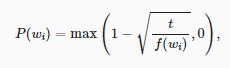

3. 中心词和上下文词的提取
4. 负采样
5. 小批量加载训练实例
6. 整合代码
7. 小结

In [6]:
import math
import os
import random
import torch
import dltools
from matplotlib import pyplot as plt

In [7]:
# 读取数据集
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = ''
    # Readthetrainingset.
    with open('E:/data/ptb/ptb.train.txt') as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

In [38]:
# 构建此表，并把频次低于10的词元替换为<unk>
vocab = dltools.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [41]:
# 下采样高频词
def subsample(sentences, vocab):
    
    # 排除未知词元'<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk]for line in sentences]
    counter = dltools.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        # return (1 - math.sqrt(1e-4 / (counter[token] / num_tokens))) < 0
        return(random.uniform(0, 1) < math.sqrt(1e-4 / (counter[token] / num_tokens)))
        

    return ([[token for token in line if keep(token)] for line in sentences],counter)

subsampled, counter = subsample(sentences, vocab)

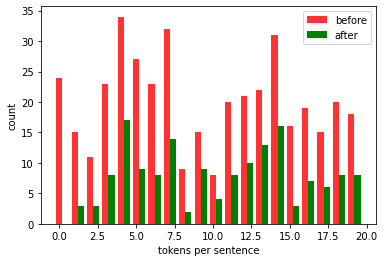

In [42]:
# 画出下采样之后的图
before = [len(x) for x in sentences[:20]] 
after = [len(x) for x in subsampled[:20]]
x = range(len(before))
plt.bar(x, height=before, width=0.4, alpha=0.8, color='red', label="before")
plt.bar([i + 0.4 for i in x], height=after, width=0.4, color='green', label="after")
plt.xlabel('tokens per sentence')
plt.ylabel("count")
plt.legend(['before', 'after'])
plt.show()

In [11]:
def compare_counts(token):
    return (f'"{token}"的数量：'f'之前={sum([l.count(token) for l in sentences])}, 'f'之后={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'"the"的数量：之前=50770, 之后=2071'

In [12]:
compare_counts('publishing')

'"publishing"的数量：之前=64, 之后=64'

In [43]:
# 将词元映射到它们在语料库中的索引
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [392, 2115, 406], [5277, 3054, 1580]]

In [44]:
# 中心词和上下文词的提取
def get_centers_and_contexts(corpus, max_window_size):
    """返回skip-gram模型中的中心词和上下文词"""
    centers, contexts = [], []
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要有2个词
        if len(line) < 2:
            continue
        centers += line
        for idx,i in enumerate(range(len(line))):  # 上下文窗口中间i
            window_size = random.randint(1, max_window_size)
            print("中心词 {} 的窗口大小：{}".format(idx,window_size))
            indices = list(range(max(0, i - window_size),min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[x] for x in indices])
    return centers, contexts

In [45]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的窗口大小：1
中心词 1 的窗口大小：2
中心词 2 的窗口大小：2
中心词 3 的窗口大小：1
中心词 4 的窗口大小：2
中心词 5 的窗口大小：2
中心词 6 的窗口大小：2
中心词 0 的窗口大小：2
中心词 1 的窗口大小：1
中心词 2 的窗口大小：1
中心词 0 的上下文词是 [1]
中心词 1 的上下文词是 [0, 2, 3]
中心词 2 的上下文词是 [0, 1, 3, 4]
中心词 3 的上下文词是 [2, 4]
中心词 4 的上下文词是 [2, 3, 5, 6]
中心词 5 的上下文词是 [3, 4, 6]
中心词 6 的上下文词是 [4, 5]
中心词 7 的上下文词是 [8, 9]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [8]


In [24]:
# 在PTB上进行中心词和背景词提取
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
'“中心词-上下文词对”的数量:{}'.format( sum([len(contexts) for contexts in all_contexts]))

'“中心词-上下文词对”的数量:1499666'

In [25]:
# 负采样-按权重抽取
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            self.candidates = random.choices(self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

In [19]:
# 示例 权重越高的索引容易被取到
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[3, 2, 3, 2, 3, 2, 2, 1, 3, 2]

In [26]:
# 返回负采样中的噪声词
def get_negatives(all_contexts, vocab, counter, K):
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75 for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

In [ ]:
# 小批量操作
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [4]:
# 小批量例子：
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


In [ ]:
# 整合后的数据加载处理模块
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,collate_fn=batchify)
    return data_iter, vocab

In [35]:
data_iter, vocab = load_data_ptb(5, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([5, 1])
contexts_negatives shape: torch.Size([5, 48])
masks shape: torch.Size([5, 48])
labels shape: torch.Size([5, 48])


In [37]:
batch

(tensor([[1259],
         [ 627],
         [5679],
         [   3],
         [ 960]]),
 tensor([[1983, 1136, 1186,   15, 3216, 5351,  512,  321, 2208, 1396,   60,  782,
            63,  929,  149,  105,  305,    7,   74,   11, 1530,    1, 5893, 2668,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
         [ 298, 1960, 1098, 1288,    6, 1689, 4808,  981, 2040, 3887,  385,   59,
          2167, 4424,   91, 4159,   65, 1271, 3621, 6020,  585, 1426, 5097,  335,
            18,  770, 5317, 1408, 5828, 3321,  836,  529, 1772,  365, 6718,  269,
           101,  209, 1450,    1,   47,  834,    8,    2,  979,   28, 4029,  471],
         [6034,    2, 4028,  829, 1042, 5340,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         